# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/kaggle/input/jo-accidents-data/JO_traffic_accidents_raw_data_En.csv")

# 1. Data Processing & Cleaning

In [2]:
# 1. Data Processing & Cleaning
# -------------------------------

print("Initial Data Info:")
print(df.info())

# Sample 5% of the data for demo purposes
df_sample = df.sample(frac=0.05, random_state=42).reset_index(drop=True)

# Use 'df_sample' for processing
df = df_sample


#Date Column is filled with ##### format, so it'll be deleted
df = df.drop('Date', axis=1)

print("Initial Data Info:")
print(df.info())


# Encoding
categoricalCols = df.select_dtypes(include=['object']).columns
labelEncoder = {}
for col in categoricalCols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    labelEncoder[col] = le 

print("\nData after encoding:")
print(df.head())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73095 entries, 0 to 73094
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Accident Type             73095 non-null  object
 1   Date                      73095 non-null  object
 2   Speed (Km)                73095 non-null  int64 
 3   Simple Injuries           73095 non-null  int64 
 4   Severe Injuries           73095 non-null  int64 
 5   Death                     73095 non-null  int64 
 6   Medium Injuries           73095 non-null  int64 
 7   Road Lanes                73095 non-null  object
 8   Road Surfuce Description  73095 non-null  object
 9   Vehicle Country           73095 non-null  object
 10  Driver Licensee Type      73095 non-null  object
 11  Road Type                 73095 non-null  object
 12  Light                     73095 non-null  object
 13  Weather                   73095 non-null  object
 14  Roa

# 2. Clustering

hier
hier
For numOfClusters: 2, the average silhouette_score is : 0.3355771909142331
For numOfClusters: 3, the average silhouette_score is : 0.35335930491627926
For numOfClusters: 4, the average silhouette_score is : 0.3603127368707496
For numOfClusters: 5, the average silhouette_score is : 0.3328110100229248
For numOfClusters: 6, the average silhouette_score is : 0.24749511811842792
For numOfClusters: 7, the average silhouette_score is : 0.25011556964487774
For numOfClusters: 8, the average silhouette_score is : 0.23761528143609983
For numOfClusters: 9, the average silhouette_score is : 0.22704001102417634
For numOfClusters: 10, the average silhouette_score is : 0.19112451435596609


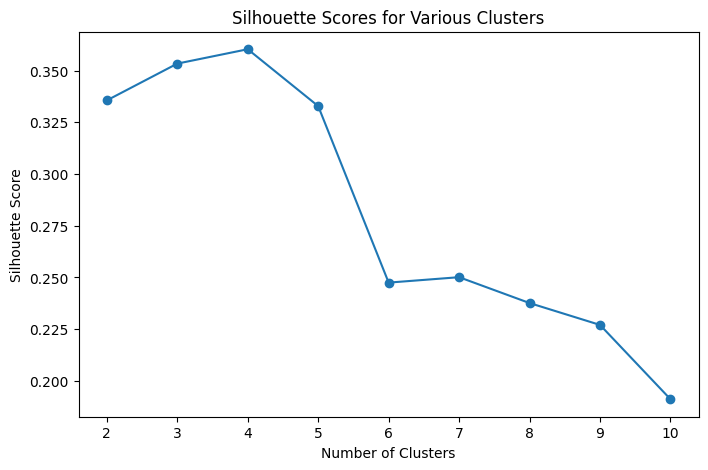


Optimal number of clusters based on silhouette Index: 4


In [3]:
# 2. Clustering: Hierarchical Clustering & Silhouette Index
# ---------------------------------------------------------
features = df.drop('Death', axis=1)
target = df['Death']

# Standardize the features
scaler = StandardScaler()
print("hier")
scaledFeatures = scaler.fit_transform(features)
print("hier")

# Hierarchical clustering with different number of clusters and silhouette scores
# Used this as a reference for clustering: https://builtin.com/machine-learning/agglomerative-clustering
silhouetteScore = []
for numOfClusters in range(2, min(11, len(df))):  
    clustering = AgglomerativeClustering(n_clusters=numOfClusters, affinity='euclidean', linkage='ward')
    clusterLabels = clustering.fit_predict(scaledFeatures)
    silhouette_avg = silhouette_score(scaledFeatures, clusterLabels)
    silhouetteScore.append(silhouette_avg)
    print(f"For numOfClusters: {numOfClusters}, the average silhouette_score is : {silhouette_avg}")


# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, len(silhouetteScore) + 2), silhouetteScore, marker='o')
plt.title('Silhouette Scores for Various Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the optimal number of clusters
optimalClusters = np.argmax(silhouetteScore) + 2
print(f"\nOptimal number of clusters based on silhouette Index: {optimalClusters}")

# Perform clustering
clustering = AgglomerativeClustering(n_clusters=optimalClusters, affinity='euclidean', linkage='ward')
clusterLabels = clustering.fit_predict(scaledFeatures)
df['Cluster'] = clusterLabels  

# 3. Feature Selection

In [4]:
# 3. Feature Selection: Using Mean Decrease Accuracy (MDA)
# --------------------------------------------------------
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# baseline accuracy
baselineAccuracy = rf.score(X_test, y_test)
print(f"\nBaseline accuracy: {baselineAccuracy}")

# MDA Implementation
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature importances
print("\nFeature importances:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Select top features
topN = 5
topFeatures = [X.columns[indices[f]] for f in range(topN)]
print(f"\nTop {topN} features:")
print(topFeatures)


Baseline accuracy: 0.9972652689152234

Feature importances:
1. Feature Driver Age (0.13244531908968776)
2. Feature Medium Injuries (0.10730288257214077)
3. Feature City (0.09975024042417019)
4. Feature Speed (Km) (0.0990542741777673)
5. Feature Driver Mistake (0.09850228601516858)
6. Feature Accident Type (0.09823516565267533)
7. Feature Simple Injuries (0.08385087025146357)
8. Feature Number of Cars (0.07690494119625114)
9. Feature Light (0.05111933299529273)
10. Feature Road Proerties (0.0400561591966359)
11. Feature Driver Licensee Type (0.04000512381210327)
12. Feature Vehicle type (0.028422086197737464)
13. Feature Road Lanes (0.025689036659833155)
14. Feature Severe Injuries (0.014085205075338844)
15. Feature Sex (0.00283004981881473)
16. Feature Weather (0.0016136386304137112)
17. Feature Road Surfuce Description (0.00013139527420152317)
18. Feature Vehicle Country (1.465306749086731e-06)
19. Feature Road Type (5.276535551377012e-07)

Top 5 features:
['Driver Age', 'Medium Inju

# 4. 5.0 DT (with Entropy instead)


Decision Tree Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1094
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2

    accuracy                           1.00      1097
   macro avg       0.33      0.33      0.33      1097
weighted avg       0.99      1.00      1.00      1097

Accuracy: 0.9963536918869644


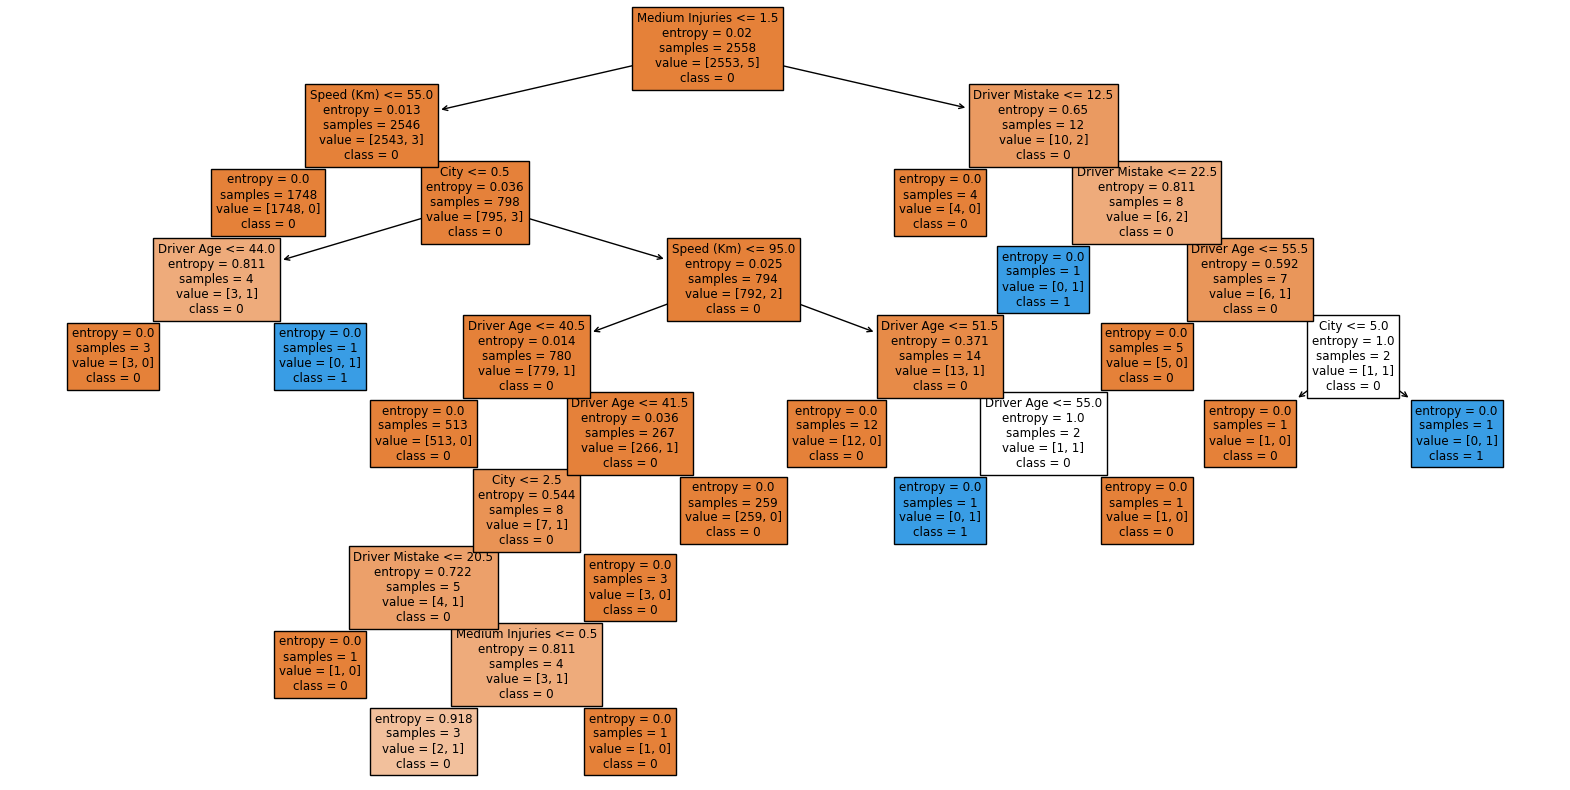


Decision Tree Rules:
|--- Medium Injuries <= 1.50
|   |--- Speed (Km) <= 55.00
|   |   |--- class: 0
|   |--- Speed (Km) >  55.00
|   |   |--- City <= 0.50
|   |   |   |--- Driver Age <= 44.00
|   |   |   |   |--- class: 0
|   |   |   |--- Driver Age >  44.00
|   |   |   |   |--- class: 1
|   |   |--- City >  0.50
|   |   |   |--- Speed (Km) <= 95.00
|   |   |   |   |--- Driver Age <= 40.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Driver Age >  40.50
|   |   |   |   |   |--- Driver Age <= 41.50
|   |   |   |   |   |   |--- City <= 2.50
|   |   |   |   |   |   |   |--- Driver Mistake <= 20.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Driver Mistake >  20.50
|   |   |   |   |   |   |   |   |--- Medium Injuries <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Medium Injuries >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- City >  2.50
|   |   |   |   |  

In [5]:
# 4. C5.0 Decision Tree (DT with Entropy)
# ----------------------
# Using only the top features selected
X_top = X[topFeatures]

# Split data with top features
X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=42)

# Build the decision tree classifier
dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
dtc.fit(X_train_top, y_train)

# Predictions
y_pred = dtc.predict(X_test_top)

# Evaluation
print("\nDecision Tree Classifier Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Visualize the decision tree
classNames = [str(cls) for cls in dtc.classes_]
plt.figure(figsize=(20,10))
tree.plot_tree(dtc, feature_names=topFeatures, class_names=classNames, filled=True)
plt.show()

# Extract rules from the tree
r = export_text(dtc, feature_names=topFeatures)
print("\nDecision Tree Rules:")
print(r)

# 5. Results
# Print list of features used in the Decision Tree
treeFeatureIndices = dtc.tree_.feature
featureIndices = np.unique(treeFeatureIndices[treeFeatureIndices >= 0])
dtFeatures = [topFeatures[i] for i in featureIndices]

print("\nFeatures used in the Decision Tree:")
print(dtFeatures)